# Efectos de localidad espacial

El propósito de estos apuntes es mostrar como el orden en que los elementos de un arreglo están distribuidos en la memoria, y la forma en como son leídos afectan al tiempo de ejecución de una función. En particular, el estudio estará centrado en la operación del producto Matriz-Vector.

## Dependencias

In [1]:
import numpy as np
import ctypes
import time
import statistics
from utilities import filtro_mediana
import matplotlib.pyplot as plt

Los datos de memoria caché son los siguientes:

In [2]:
! lscpu | grep "cache"

L1d cache:                       128 KiB
L1i cache:                       128 KiB
L2 cache:                        1 MiB
L3 cache:                        48 MiB


## Row-Major Row-View

En este caso los elementos de la matriz han sido escritos en memoria, fila por fila, y serán leídos también fila por fila.

In [3]:
%%file matvecRMRV.c
void matvecRMRV(double *A, double *x, double *b, int N)
{
    float tmp = 0.0;
    for(int i = 0; i < N; i++)
    {
        tmp = 0.0;
        for(int j = 0; j < N; j++)
        {
            tmp += A[i*N + j]*x[j];
        }
        b[i] = tmp;
    }
}

Writing matvecRMRV.c


In [4]:
! gcc -c -fpic matvecRMRV.c -o matvecRMRV.o
! gcc -shared matvecRMRV.o -o matvecRMRV.so

In [5]:
def ctypes_matvecRMRV():
    # ruta de la shared library
    lib = ctypes.CDLL('./matvecRMRV.so')
    
    # tipo de los argumentos
    lib.matvecRMRV.argtypes = [
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        ctypes.c_int
    ]
    
    # se devuelve la función configurada
    return lib.matvecRMRV

In [6]:
matvecRMRV = ctypes_matvecRMRV()

In [7]:
n = 2048
A = np.random.rand(n,n)
Y = A.flatten()
x = np.random.rand(n,1)
bref = np.dot(A,x)
bRMRV = np.zeros_like(x)
matvecRMRV(Y,x,bRMRV,n)
np.linalg.norm(bref-bRMRV)/np.linalg.norm(bref)

6.031283029831271e-07

## Row-Major Column-View

En este caso los elementos de la matriz han sido escritos en memoria, fila por fila, y serán leídos columna por columna.

In [8]:
%%file matvecRMCV.c
void matvecRMCV(double *A, double *x, double *b, int N)
{
    float tmp = 0.0;
    for(int j = 0; j < N; j++)
    {
        for(int i = 0; i < N; i++)
        {
            b[i] += A[i*N + j]*x[j];
        }
    }
}

Writing matvecRMCV.c


In [9]:
! gcc -c -fpic matvecRMCV.c -o matvecRMCV.o
! gcc -shared matvecRMCV.o -o matvecRMCV.so

In [10]:
def ctypes_matvecRMCV():
    # ruta de la shared library
    lib = ctypes.CDLL('./matvecRMCV.so')
    
    # tipo de los argumentos
    lib.matvecRMCV.argtypes = [
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        ctypes.c_int
    ]
    
    # se devuelve la función configurada
    return lib.matvecRMCV

In [11]:
matvecRMCV = ctypes_matvecRMCV()

In [12]:
n = 2048
A = np.random.rand(n,n)
Y = A.flatten()
x = np.random.rand(n,1)
bref = np.dot(A,x)
# zeros_like te da un arreglo con las mismas dimensiones que el argumento, pero lleno de zeros
bRMCV = np.zeros_like(bref)
matvecRMCV(Y,x,bRMCV,n)
# error relativo
np.linalg.norm(bref-bRMCV)/np.linalg.norm(bref)

1.3476494042634617e-15

## Column-Major Row-View

En este caso los elementos de la matriz han sido escritos en memoria columna por columna, y serán leídos fila por fila.

In [13]:
%%file matvecCMRV.c
void matvecCMRV(double *A, double *x, double *b, int N)
{
    float tmp = 0.0;
    for(int i = 0; i < N; i++)
    {
        tmp = 0.0;
        for(int j = 0; j < N; j++)
        {
            tmp += A[i + j*N]*x[j];
        }
        b[i] = tmp;
    }
}

Writing matvecCMRV.c


In [14]:
! gcc -c -fpic matvecCMRV.c -o matvecCMRV.o
! gcc -shared matvecCMRV.o -o matvecCMRV.so

In [15]:
def ctypes_matvecCMRV():
    # ruta de la shared library
    lib = ctypes.CDLL('./matvecCMRV.so')
    
    # tipo de los argumentos
    lib.matvecCMRV.argtypes = [
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        ctypes.c_int
    ]
    
    # se devuelve la función configurada
    return lib.matvecCMRV

In [16]:
matvecCMRV = ctypes_matvecCMRV()

In [17]:
n = 2048
A = np.random.rand(n,n)
Y = np.transpose(A).flatten()
x = np.random.rand(n,1)
bref = np.dot(A,x)
# zeros_like te da un arreglo con las mismas dimensiones que el argumento, pero lleno de zeros
bCMRV = np.zeros_like(bref)
matvecCMRV(Y,x,bCMRV,n)
# error relativo
np.linalg.norm(bref-bCMRV)/np.linalg.norm(bref)

6.1610457520865e-07

## Column-Major Column-View

En este caso los elementos de la matriz han sido escritos en memoria columna por columna, y serán leídos también columna por columna.

In [18]:
%%file matvecCMCV.c
void matvecCMCV(double *A, double *x, double *b, int N)
{
    for(int j = 0; j < N; j++)
    {
        for(int i = 0; i < N; i++)
        {
            b[i] += A[i + j*N]*x[j];
        }
    }
}

Writing matvecCMCV.c


In [19]:
! gcc -c -fpic matvecCMCV.c -o matvecCMCV.o
! gcc -shared matvecCMCV.o -o matvecCMCV.so

In [20]:
def ctypes_matvecCMCV():
    # ruta de la shared library
    lib = ctypes.CDLL('./matvecCMCV.so')
    
    # tipo de los argumentos
    lib.matvecCMCV.argtypes = [
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        np.ctypeslib.ndpointer(dtype=np.float64),
        ctypes.c_int
    ]
    
    # se devuelve la función configurada
    return lib.matvecCMCV

In [21]:
matvecCMCV = ctypes_matvecCMCV()

In [22]:
n = 2048
A = np.random.rand(n,n)
Y = np.transpose(A).flatten()
x = np.random.rand(n,1)
bref = np.dot(A,x)
# zeros_like te da un arreglo con las mismas dimensiones que el argumento, pero lleno de zeros
bCMCV = np.zeros_like(bref)
matvecCMCV(Y,x,bCMCV,n)
# error relativo
np.linalg.norm(bref-bCMCV)/np.linalg.norm(bref)

1.356504736804825e-15

## Mediciones

In [23]:
trmrv = []
trmcv = []
tcmrv = []
tcmcv = []
ns = 2**np.arange(10,14)
veces = 40
for n in ns:
    trmrvi = []
    trmcvi = []
    tcmrvi = []
    tcmcvi = []
    for j in range(veces):
        # datos
        A = np.random.rand(n,n)
        x = np.random.rand(n,1)
        
        # entradas RM
        Arm = A.flatten()
        
        # entradas CM
        Acm = np.transpose(A).flatten()
        
        # referencia
        bref = np.dot(A,x)
        
        # salidas
        bRMRV = np.zeros_like(bref)
        bRMCV = np.zeros_like(bref)
        bCMRV = np.zeros_like(bref)
        bCMCV = np.zeros_like(bref)
        
        # tiempo RMRV
        t = time.time()
        matvecRMRV(Arm,x,bRMRV,n)
        trmrvi.append(time.time() - t)
    
        # tiempo RMCV
        t = time.time()
        matvecRMCV(Arm,x,bRMCV,n)
        trmcvi.append(time.time() - t)
        
        # tiempo CMRV
        t = time.time()
        matvecCMRV(Acm,x,bCMRV,n)
        tcmrvi.append(time.time() - t)
        
        # tiempo CMCV
        t = time.time()
        matvecCMCV(Acm,x,bCMCV,n)
        tcmcvi.append(time.time() - t)
    
    trmrv.append(statistics.mean(filtro_mediana(trmrvi,9)))
    trmcv.append(statistics.mean(filtro_mediana(trmcvi,9)))
    tcmrv.append(statistics.mean(filtro_mediana(tcmrvi,9)))
    tcmcv.append(statistics.mean(filtro_mediana(tcmcvi,9)))

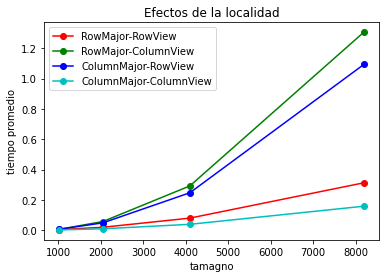

In [24]:
plt.plot(ns, trmrv, 'r-o', label='RowMajor-RowView')
plt.plot(ns, trmcv, 'g-o', label='RowMajor-ColumnView')
plt.plot(ns, tcmrv, 'b-o', label='ColumnMajor-RowView')
plt.plot(ns, tcmcv, 'c-o', label='ColumnMajor-ColumnView')
plt.title('Efectos de la localidad')
plt.xlabel('tamagno')
plt.ylabel('tiempo promedio')
plt.legend()
plt.show()

In [25]:
! rm *.o
! rm *.so
! rm *.c